# Guitar ETL and EDA

In [1]:
import os, io, requests, csv, sys

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from scipy.stats import boxcox
from operator import itemgetter
from datetime import datetime

In [2]:
sys.path.insert(0, 'objects')
sys.path.insert(0, 'data')
sys.path.insert(0, 'pickles')

### Here's a Class with *Lots* of Attributes (Features)

Some ducking was required to handle auctions missing certain details.

In [3]:
from Shade_Sale import Shade_Sale

### Loop Through All Item JSON Data Files, Instantiate Class Objects

In [4]:
file_names = [name for name in os.listdir('data/specs/') if not name.startswith('.')] # Ignores hidden files on mac


In [5]:
items = []
for filename in file_names:
    try:
        this_item = Shade_Sale('data/listings', 'data/specs', filename)
        if "LOT" not in this_item.title.upper():# and this_item.price > 110 and this_item.price < 890:
            items.append(this_item)
    except ValueError:
        print('valerror')
        pass

valerror
valerror
valerror
valerror
valerror
valerror


In [6]:
len(items) # Our sample size.

173

********

## EDA

**********

__Price Distribution:__

In [7]:
orig_prices = pd.Series([item.price for item in items], name = 'prices')

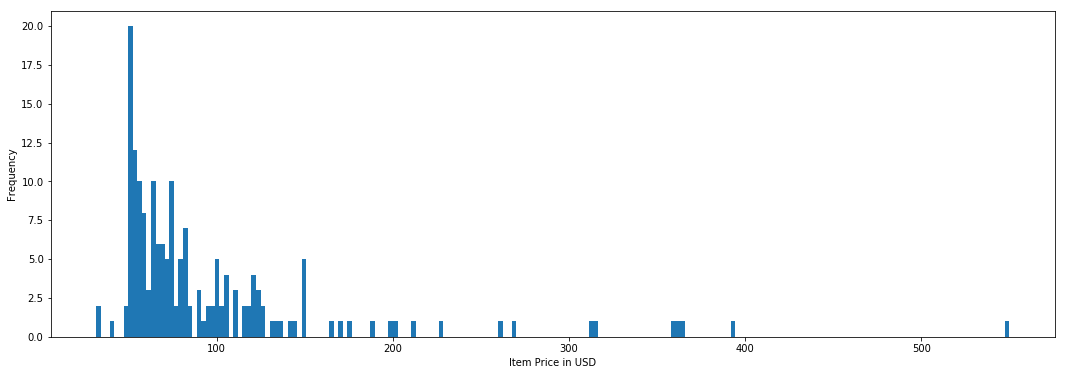

In [8]:
plt.figure(figsize = (18,6))
plt.hist(orig_prices, bins=200)
plt.ylabel('Frequency')
plt.xlabel('Item Price in USD')
plt.show()

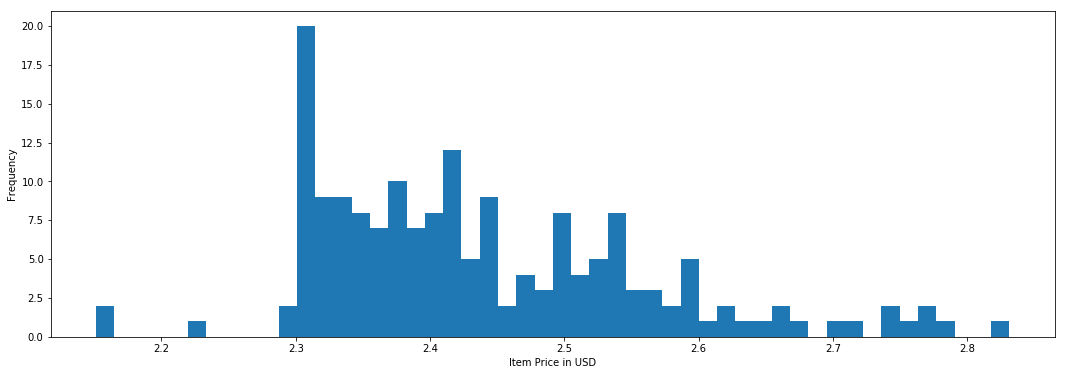

In [9]:
# prices = pd.Series([axe.price_usd for axe in axes])

BOXCOX_LAM = -.3

prices = pd.Series(boxcox([item.price for item in items], lmbda=BOXCOX_LAM), name = 'price')

plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Item Price in USD')
plt.show()

Some of the most expensive guitars:

In [10]:
spensive = [{'name':item.title,
             'price': item.price,
            'year':item.year} for item in items]
sorted(spensive, key=itemgetter('price'))[-5:]

[{'name': 'Oakley x squared x metal Ruby Sunglasses',
  'price': 360.0,
  'year': None},
 {'name': 'Oakley X Metal X Squared', 'price': 361.0, 'year': None},
 {'name': 'Louis Vuitton X Supreme City Mask Sunglasses',
  'price': 364.88,
  'year': None},
 {'name': 'Super Rare OAKLEY JULIET X METAL  /  RUBY IRIDIUM LENS  # 04-116',
  'price': 393.1,
  'year': None},
 {'name': 'louis vuitton millionaire sunglasses 100 % authentic rare',
  'price': 550.0,
  'year': None}]

**********

__Text Fields, for NLP:__

Listing Title:

In [11]:
[item.title for item in items][:20] # All listings must have a title

['Oakley Eye Patch 2 Polished Black Violet Iridium 009136-06 RARE',
 'Kaenon Titanium Rhino Sunglasses | Unisex | Polarized | Made in Italy',
 'MAUI JIM MJ Sport MJ-405   Made in Japan Brown',
 'Oakley Crosshair Ti Titanium ',
 'Oakley FMJ Red Scar Sunglasses',
 'Oakley Targetline Sunglasses  Matte Black | Prizm Dark Golf ',
 'Oakley Radar EV Path Team Colors Sunglasses Blue Plus Red Iridium Extra..',
 'Oakley Eyepatch 2 Custom',
 'Oakley Made In USA 03-474 60[]17 Gascan White Sunglasses / Frames',
 "GUCCI AVIATOR MEN'S SUNGLASSES. ",
 'Oakley Jawbreaker Sport Sky Sapphire Iridium Sunglasses',
 'Oakley Crosshair Lead Polarized Prizm Black Iridium Sunglasses',
 'Oakley Batwolf Sunglasses 009101 54  16-136',
 'Oakley Crosshair 2.0 Silver',
 'Oakley Batwolf Sunglasses',
 'Oakley Deviation Sunglasses Polished Chrome / Fire Iridium ',
 " PERSOL RATTI  61** Meflecto Sunglasses Massive Vintage Frame Eyeglasse 60'S",
 'Persol mens sunglasses: brown and light brown frame; dark lens & turquoise 

Mean Length of Title:

In [12]:
mean_title_len = sum(len(item.title) for item in items)/len(items)
print(f'{round(mean_title_len)} characters per title on average.')

58 characters per title on average.


In [13]:
print(f'{round(sum(1 for item in items if len(item.title) < 46) / len(items)*100,2)}% of listings have less than 46 characters in the title.')


27.75% of listings have less than 46 characters in the title.


Maybe "title has length less than 46 characters" should be a one-hot variable.

Listing __Sub__titles:

In [14]:
[item.subtitle for item in items if item.subtitle != None][-5:]
print(f'{round(((len([item.subtitle for item in items if item.subtitle != None]) / len(items))*100),2)}% of listings include a subtitle.')

1.73% of listings include a subtitle.


Condition Descriptions:

In [15]:
[item.condition_description for item in items if item.condition_description != None][-5:]
print(f'{round(((len([item.condition_description for item in items if item.condition_description != None]) / len(items))*100),2)}% of listings include a condition description.')

27.17% of listings include a condition description.


Example of Description Full Text:

In [16]:
print([item.description for item in items][20:22])
print(f'\n{round(((len([item.description for item in items if item.description != None]) / len(items))*100),2)}% of listings include a text description.')

['The frames are in good shape but the lenses are scratched. It was hard to photograph but the right lens is worse. Please review the photos before you purchase. Thanks!', 'Oakley TwoFace Polished Polarized Sunglasses - Black (Includes Spare Lenses). Two sets of lenses, both mirror style. Great condition, like new. Condition is Pre-owned. Dispatched with USPS First Class Package.']

100.0% of listings include a text description.


***********

__Number of Pics on eBay listing:__

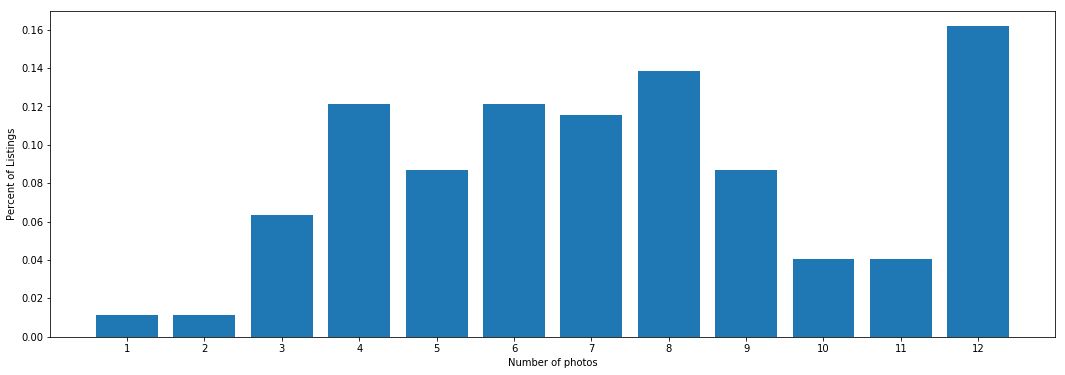

In [17]:
pic_quants = pd.Series([item.pic_quantity for item in items]).value_counts()
plt.figure(figsize = (18,6))
plt.bar(pic_quants.index, pic_quants.values/len(items))
plt.xticks(pic_quants.index)
plt.xlabel("Number of photos")
plt.ylabel("Percent of Listings")
plt.show()

In [18]:
for num_photos in range(13,0,-1):
    print(f'{round(len([item.pic_quantity for item in items if item.pic_quantity < num_photos]) / len(items) * 100, 1)}% of auctions have less than {num_photos} photos.')

100.0% of auctions have less than 13 photos.
83.8% of auctions have less than 12 photos.
79.8% of auctions have less than 11 photos.
75.7% of auctions have less than 10 photos.
67.1% of auctions have less than 9 photos.
53.2% of auctions have less than 8 photos.
41.6% of auctions have less than 7 photos.
29.5% of auctions have less than 6 photos.
20.8% of auctions have less than 5 photos.
8.7% of auctions have less than 4 photos.
2.3% of auctions have less than 3 photos.
1.2% of auctions have less than 2 photos.
0.0% of auctions have less than 1 photos.


__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [19]:
[item.pic for item in items][:5] # Just first five. You get it

['http://thumbs4.ebaystatic.com/m/mf1pg4m4EoQT2zC6OX0pbgw/140.jpg',
 'http://thumbs4.ebaystatic.com/m/m9Kjm23pLoQtrC97Xw3a1eQ/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mVUN-lMEqRdgDvgYejw5nsw/140.jpg',
 'http://thumbs3.ebaystatic.com/m/mgg0LIPhN1GXcL4tPHQVClw/140.jpg',
 'http://thumbs1.ebaystatic.com/m/mTYSF_T44FEch9JkZfti2yg/140.jpg']

**********

**Shipping Type:**

In [20]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

NameError: name 'axes' is not defined

<Figure size 1296x432 with 0 Axes>

In [ ]:
free = pd.Series([axe.price_shipping == 0 for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(free.values, explode=[.01,.01], labels=['Charge for Shipping', 'Free Shipping'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [ ]:
print(f'${round(sum(axe.price_shipping for axe in axes) / len([axe.price_shipping for axe in axes]),2)} - Average shipping cost (including free shipping)')

In [ ]:
print(f'${round(sum(axe.price_shipping for axe in axes if axe.price_shipping != 0) / len([axe.price_shipping for axe in axes if axe.price_shipping]),2)} - Average shipping cost (if charging for shipping)')

**Offering Expedited Shipping:**

In [ ]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__Listing Types:__

In [ ]:
listing_types = pd.Series([axe.listing_type for axe in axes if axe.listing_type != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(listing_types.values, 
        labels = listing_types.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=45,
        explode = np.full(len(listing_types), .02))
plt.show()

****

__TEMPORAL STUFF__

**Handling Time in Days:**

In [ ]:
plt.figure(figsize = (18,6))
times = pd.Series([axe.ship_handling_time for axe in axes if axe.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))-.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

In [ ]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Duration of Auction in Days')
plt.show()

**Weekday of Auction Start:**

In [ ]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

In [ ]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

In [ ]:
start_hours = pd.Series([axe.start_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((start_hours.index-5+24)%24, start_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions Start Hour of Day — NYC Time")
plt.show()

In [ ]:
end_hours = pd.Series([axe.end_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((end_hours.index - 5 + 24)%24, end_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions End Hour of Day - NYC Time")
plt.show()

**Percentage of Auctions Offering Returns:**

In [ ]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(returns.values, explode=[.1,.1], labels=['Not offering Returns', 'Offering Returns'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Return Time Window** (of those offering returns):

In [ ]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time > 0]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index, 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering AutoPay:**

In [ ]:
auto = pd.Series([axe.autopay for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(auto.values, explode=[.1,.1], 
        labels=['No AutoPay', 'AutoPay'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__"Best Offer":__

In [ ]:
print(f'{round((sum(axe.best_offer_enabled for axe in axes) / len(axes)*100),2)}% of listings have "Best Offer" enabled. (Potential buyers are allowed to negotiate price)')

***

**Countries of Sellers:**

In [ ]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=['USA', 'Japan', 'Canada', 
                                  'Other','Great Britain'], 
                            explode = np.full(len(countries), .5), 
        autopct='%1.1f%%',
       shadow = True)
plt.show()

__Seller Karma:__

Ebay Seller Feedback Score:

In [ ]:
scores = pd.Series([axe.seller_feedback_score for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

In [ ]:
scores.min(), scores.max()

eBay Positive Feedback Percentage:

In [ ]:
scores = pd.Series([axe.seller_positive_percent for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

***

## ITEM DETAILS

__Countries of Manufacture:__

In [ ]:
plt.figure(figsize = (8,8))
countries = pd.Series([item.country_manufacture for item in items]).value_counts()
plt.pie(countries.values, labels= countries.index, explode = np.full(len(countries), .1), 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [ ]:
per = round(sum(pd.Series(len([axe.country_manufacture for axe in items if axe.country_manufacture != "UNKNOWN"]) / len(items))*100),2)
print(f'{per}% of auctions list a country of manufacture where they\'re supposed to.')

In [ ]:
items[10]._Shade_Sale__body

**Properties:**

* Temple length (?)
* Country of mfctr
* Modified Item (?)
* Frame material
* Frame color
* Lens Color
* Lens technology
* Brand
* Model (too many)
* Style
* Protection

In [ ]:
years = pd.Series([axe.year for axe in axes if axe.year != None])
plt.figure(figsize = (18,6))
plt.hist(years, bins=30)
plt.xticks(np.arange(1900,2021,5))
plt.show()

In [ ]:
print(f'{round((len(years) / len(axes) * 100),2)}% of auctions include year data...')

### What if we just bin years, drawing the line where it really matters?

***

__US Seller Locations, by Zip Code:__

In [ ]:
sales = [(axe.zip[0], axe.start_time) for axe in axes if axe.country_seller == 'US' and axe.zip != None]

In [ ]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [ ]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [ ]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [ ]:
def write_kepler_csv():
    with open('../_for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{round((omissions/len(sales))*100, 2)}% of zips were not found")

In [ ]:
write_kepler_csv()

***

__Guitar Brands__

In [21]:
brand_counts = pd.Series([item.brand for item in items]).value_counts()

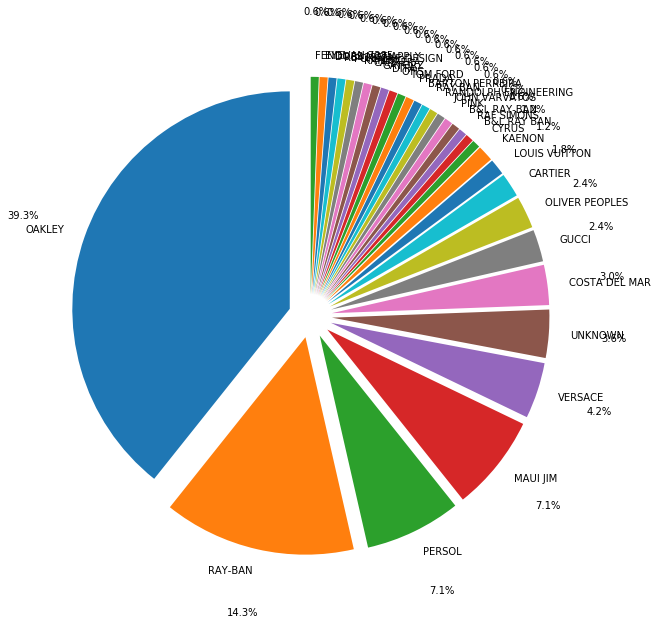

In [22]:
plt.figure(figsize = (10,10))
plt.pie(brand_counts.values, 
        labels = brand_counts.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=90,
        explode = np.full(len(brand_counts), .1))
plt.show()

In [ ]:
print(f'{round((len([axe.brand for axe in axes if axe.brand != None]) * 100 / len(axes) ),2)}% of auctions include brand data.')

**Individual Guitar Models**

In [ ]:
model_counts = pd.Series([axe.model for axe in axes if axe.brand != None]).value_counts()

There is such a great variety of guitar models. Slivers of the pie smaller than "SQUIER" (rightmost tiny sliver) have been lumped into "OTHER".

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(model_counts.values, labels = model_counts.index,
                            explode = np.full(len(model_counts), .01))
plt.show()

***

__Right or Left Handed:__

In [ ]:
RL = pd.Series([axe.right_left_handed for axe in axes if axe.right_left_handed != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(RL.values, labels = RL.index,
                            explode = np.full(len(RL), .1))
plt.show()

In [ ]:
print(f'{round((len([axe.right_left_handed for axe in axes if axe.right_left_handed != None]) / len(axes)),2)}% of auctions include dexterity.')

***

__Body Types:__

In [ ]:
plt.figure(figsize=(10,10))
bodies = pd.Series([axe.body_type for axe in axes if axe.body_type != None]).value_counts()
plt.pie(bodies.values, 
        labels = bodies.index,
       explode = np.full(len(bodies), .1))
plt.show()

In [ ]:
print(f'{sum(bodies.values)} aka {round(sum(bodies.values) / len(axes) * 100, 2)}% of listings provide a body type.')

****

__Number of Strings:__

In [ ]:
strings = pd.Series([axe.string_config for axe in axes if axe.string_config != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(strings.values, 
        labels = strings.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=0,
        explode = np.full(len(strings), .8))
plt.show()

In [ ]:
print(f'{sum(strings.values)} aka {round(sum(strings.values) / len(axes) * 100, 2)}% of listings provide a string count.')